# Train Variational Quantum Circuits by using evovaq and Qiskit

## 1) Training a Variational Quantum Classifier through a Memetic Algorithm

#### Importing modules

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit import Aer, execute
from evovaq.problem import Problem
from evovaq.GeneticAlgorithm import GA
from evovaq.HillClimbing import HC
from evovaq.MemeticAlgorithm import MA
import evovaq.tools.operators as op
import numpy as np

#### Uploading the classical data

In [2]:
iris = load_iris()

# For the sake of simplicity, we consider all the four features but only two classes
iris_data = iris.data[:100, :4]
iris_target = iris.target[:100]   # 0 or 1

# Split into train and test subsets
train_data, test_data, train_labels, test_labels = train_test_split(iris_data, iris_target, test_size=0.2,
                                                                    random_state=42)

# Pre-process data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

#### Building the Variational Quantum Classifier

In [3]:
# Encode classical data in a quantum system through a FeatureMap
dim = train_data.shape[1]
feature_map = ZZFeatureMap(dim, reps=1, entanglement='linear')

# Define an Ansatz to be trained
ansatz = RealAmplitudes(num_qubits=dim, reps=1, entanglement='circular')

# Put together our quantum classifier
circuit = feature_map.compose(ansatz)

# Measure all the qubits to retrieve label information
circuit.measure_all()

In [4]:
def get_label_prediction(circuit, features, params):
    # Bind the parameters to our quantum classifier
    bound_circuit = circuit.bind_parameters(np.concatenate((features,params)))
    backend = Aer.get_backend('qasm_simulator')
    counts = execute(bound_circuit, backend).result().get_counts()
    
    # Read the label by considering the parity mapping of the final quantum state
    parity_1 = 0
    for state, count in counts.items():
        if state.count('1') % 2 == 1:
            parity_1 += count
    return parity_1 / sum(counts.values())

#### Defining the cost function to be minimized

In [5]:
def cost_function(params):
    predictions = [get_label_prediction(circuit, features, params) for features in train_data]
    return log_loss(train_labels, predictions)

#### Setting up the problem

In [6]:
problem = Problem(ansatz.num_parameters, ansatz.parameter_bounds, cost_function)

#### Defining a Memetic Algorithm

In [7]:
# Define the global search method
global_search = GA(selection=op.sel_tournament, crossover=op.cx_uniform, mutation=op.mut_gaussian, sigma=0.2, mut_indpb=0.15,
               cxpb=0.9, tournsize=5)

# Create a neighbour of a possibile solution
def get_neighbour(problem, current_solution):
    neighbour = current_solution.copy()
    index = np.random.randint(0, len(current_solution))
    _min, _max = problem.param_bounds[0]
    neighbour[index] = np.random.uniform(_min, _max)
    return neighbour

# Define the local search method
local_search = HC(generate_neighbour=get_neighbour)

# Compose the global and local search method for a Memetic Algorithm 
optimizer = MA(global_search=global_search.evolve_population, sel_for_refinement=op.sel_best, local_search=local_search.stochastic_var, frequency=0.1, intensity=10)


#### Training our VQC

In [8]:
res = optimizer.optimize(problem, 10, max_gen=10, verbose=True, seed=42)
res

Generations:   0%|                                      | 0/10 [00:00<?, ?gen/s]

********** Execution #1 **********
gen    nfev    min       max      mean      std
-----  ------  --------  -------  --------  --------
0      10      0.574194  1.01087  0.777387  0.118212


Generations:  10%|███                           | 1/10 [00:07<01:09,  7.68s/gen]


1      20      0.549579  0.824715  0.724881  0.0867576


Generations:  20%|██████                        | 2/10 [00:14<00:58,  7.29s/gen]


2      18      0.519661  0.737288  0.624565  0.076709


Generations:  30%|█████████                     | 3/10 [00:22<00:52,  7.46s/gen]


3      20      0.512227  0.603781  0.554474  0.0314989


Generations:  40%|████████████                  | 4/10 [00:29<00:44,  7.39s/gen]


4      19      0.506354  0.553874  0.527675  0.0165829


Generations:  50%|███████████████               | 5/10 [00:36<00:36,  7.36s/gen]


5      19      0.487778  0.514964  0.507114  0.00765964


Generations:  60%|██████████████████            | 6/10 [00:44<00:29,  7.34s/gen]


6      19      0.487778  0.510338  0.499565  0.00927926


Generations:  70%|█████████████████████         | 7/10 [00:51<00:22,  7.45s/gen]


7      20      0.485524  0.500729  0.491166  0.00411343


Generations:  80%|████████████████████████      | 8/10 [00:58<00:14,  7.27s/gen]


8      18      0.485524  0.506184  0.493225  0.00625882


Generations:  90%|███████████████████████████   | 9/10 [01:06<00:07,  7.28s/gen]


9      19      0.485524  0.494877  0.490388  0.00262625


Generations: 100%|█████████████████████████████| 10/10 [01:13<00:00,  7.28s/gen]


10     19      0.4826  0.507815  0.491194  0.0067016


  fun: 0.48260042185591684
  gen: 10
  log: {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'nfev': [10, 20, 18, 20, 19, 19, 19, 20, 18, 19, 19], 'min': [0.5741943431806411, 0.5495792409760082, 0.5196605664809661, 0.5122270310580073, 0.5063544128367315, 0.48777758944625205, 0.48777758944625205, 0.4855235783395476, 0.4855235783395476, 0.4855235783395476, 0.48260042185591684], 'max': [1.0108700876409014, 0.8247149305827991, 0.7372875746767409, 0.6037810463616139, 0.5538735167983232, 0.5149636544597807, 0.5103379175913295, 0.5007291786843474, 0.5061838813178279, 0.49487692318985294, 0.5078148595811571], 'mean': [0.7773865786237139, 0.7248805833709737, 0.624564804037709, 0.5544738494343432, 0.5276751585322951, 0.5071143411368311, 0.49956486395235433, 0.491165859240668, 0.4932252838704291, 0.49038829387334315, 0.49119421090738113], 'std': [0.11821196539990832, 0.08675763260140516, 0.07670898880389071, 0.03149892902008803, 0.016582930547904655, 0.0076596415234313035, 0.00927925771628771, 0.00411

#### Testing the optimal solution found

In [9]:
test_predictions = [1 if get_label_prediction(circuit, features, res.x) > 0.5 else 0 for features in test_data]
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on the test subset:", test_accuracy)

Accuracy on the test subset: 0.9


## 2) QAOA trained by a Particle Swarm Optimization algorithm to solve MaxCut problem

#### Importing modules

In [10]:
import networkx as nx
import numpy as np
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit_optimization.applications import Maxcut
from qiskit.circuit.library import QAOAAnsatz
from evovaq.problem import Problem
from evovaq.ParticleSwarmOptimization import PSO

#### Defining the graph

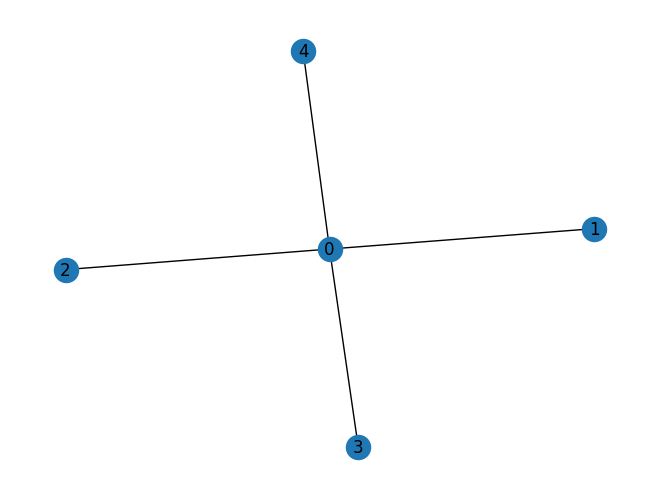

In [11]:
num_nodes = 5
edges = [(0, 1), (0, 2), (0, 3), (0, 4)]

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

#### Mapping the MaxCut problem in a QAOA circuit ansatz

##### 1 - Trasforming the MaxCut instance in a quadratic problem

In [12]:
maxcut_prob = Maxcut(G)
maxcut_qp = maxcut_prob.to_quadratic_program()
print(maxcut_qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_0*x_4 + 4*x_0 + x_1 + x_2 + x_3 + x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



##### 2 - Defining the Hamiltonian by mapping the QUBO problem in an Ising Model

In [13]:
# MaxCut problem to Hamiltonian operator
hamiltonian, offset = maxcut_qp.to_ising()

##### 3 - Building the QAOA circuit based on the MaxCut instance

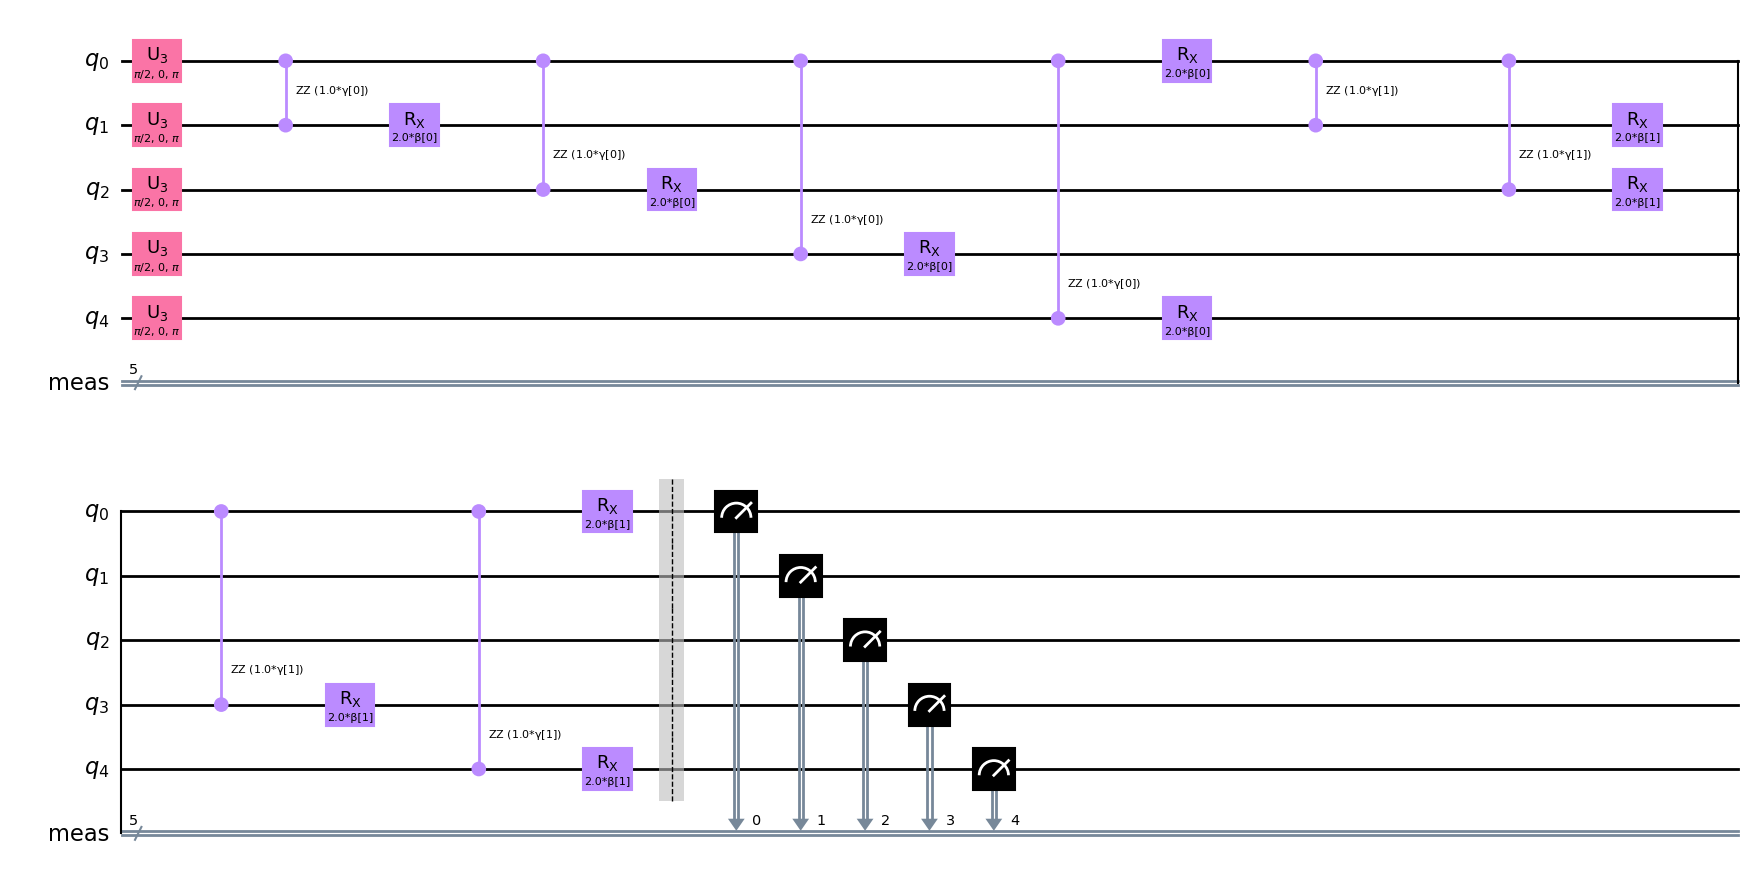

In [14]:
# QAOA ansatz circuit
qaoa_circuit = QAOAAnsatz(hamiltonian, reps=2)
qaoa_circuit.measure_all()
qaoa_circuit.decompose(reps=3).draw('mpl')

#### Defining the cost function to be minimized

In [15]:
def cost_function(params):
    backend = Aer.get_backend('qasm_simulator')
    # Bind the parameters to the QAOA circuit
    bound_qaoa_circuit = qaoa_circuit.bind_parameters(params)
    counts = execute(bound_qaoa_circuit, backend, shots=512).result().get_counts()
    cost_value = 0
    # Compute the cost value by using the maxcut objective function
    for bitstring, count in counts.items():
        cost_value -= count * maxcut_qp.objective.evaluate([int(bit) for bit in bitstring[::-1]])
    return cost_value / sum(counts.values())


#### Setting up the problem

In [16]:
qaoa_problem = Problem(qaoa_circuit.num_parameters, (0, 2 * np.pi), cost_function)

#### Defining the Particle Swarm Optimization algorithm

In [17]:
optimizer = PSO(vmin=-0.1, vmax=0.1)

#### Training the QAOA circuit

In [18]:
res = optimizer.optimize(qaoa_problem, 10, max_nfev=100, seed=42)
res


Fitness Evaluations:  20%|███▌              | 20/100 [00:00<00:00, 111.69nfev/s]

********** Execution #1 **********
gen    nfev    min       max       mean     std
-----  ------  --------  --------  -------  --------
0      10      -3.59961  -1.21289  -2.0998  0.795261

1      10      -3.69336  -1.16016  -2.06133  0.827515



Fitness Evaluations:  40%|███████▌           | 40/100 [00:00<00:00, 70.74nfev/s]


2      10      -3.52539  -1.10156  -2.01016  0.748684

3      10      -3.37695  -1.16602  -1.99609  0.70882

4      10      -3.39062  -0.621094  -1.93848  0.725515



Fitness Evaluations:  70%|█████████████▎     | 70/100 [00:01<00:00, 61.28nfev/s]


5      10      -3.56641  -0.810547  -2.06152  0.680007

6      10      -3.74805  -1.32617  -2.1293  0.685094

7      10      -3.72266  -1.22656  -2.19453  0.671043



Fitness Evaluations: 100%|██████████████████| 100/100 [00:01<00:00, 62.75nfev/s]


8      10      -3.75391  -0.927734  -2.15273  0.712836

9      10      -3.69922  -0.908203  -2.10605  0.733891


  fun: -3.75390625
  gen: 10
  log: {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'nfev': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'min': [-3.599609375, -3.693359375, -3.525390625, -3.376953125, -3.390625, -3.56640625, -3.748046875, -3.72265625, -3.75390625, -3.69921875], 'max': [-1.212890625, -1.16015625, -1.1015625, -1.166015625, -0.62109375, -0.810546875, -1.326171875, -1.2265625, -0.927734375, -0.908203125], 'mean': [-2.0998046875, -2.061328125, -2.01015625, -1.99609375, -1.9384765625, -2.0615234375, -2.129296875, -2.19453125, -2.152734375, -2.1060546875], 'std': [0.7952608162924764, 0.827514976527285, 0.748683944616005, 0.7088197122833735, 0.7255149590956633, 0.6800069124207058, 0.6850942237816521, 0.6710433852244695, 0.712836470545829, 0.7338907406430878]}
 nfev: 100
    x: array([2.78906277, 4.94085891, 1.31774472, 3.20100144])

#### Testing the optimal angles found

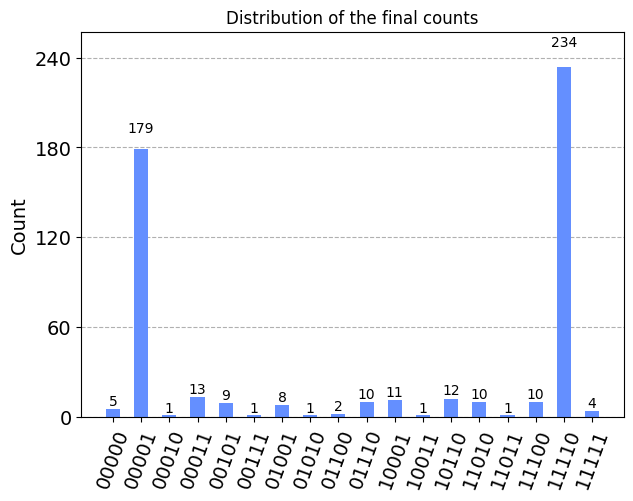

In [19]:
backend = Aer.get_backend('qasm_simulator')
trained_qaoa_circuit = qaoa_circuit.bind_parameters(res.x)
counts = execute(trained_qaoa_circuit, backend, shots=512).result().get_counts()
plot_histogram(counts, title='Distribution of the final counts')

In [20]:
bitstring = maxcut_prob.sample_most_likely(counts)
print('Optimal solution: ', bitstring)

Optimal solution:  [0 1 1 1 1]


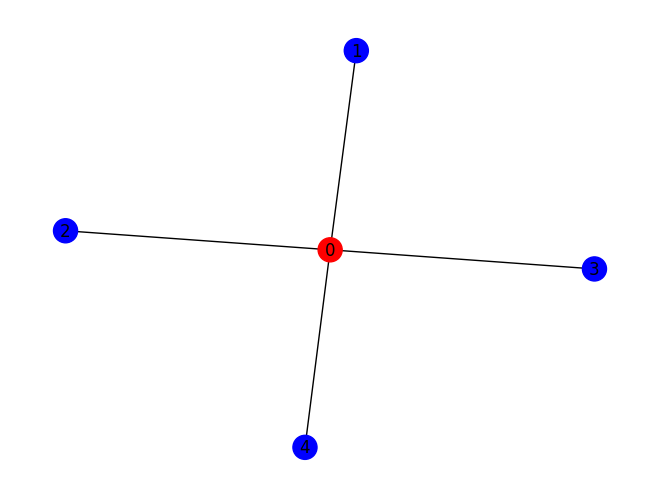

In [21]:
maxcut_prob.draw(bitstring)